# Introduction
Image captioning is a popular research area of Artificial Intelligence that deals with image understanding and a language description for that image. Generating well-formed sentences requires both syntactic and semantic understanding of the language. Being able to describe the content of an image using accurately formed sentences is a very challenging task, but it could also have great impact, by helping visually impaired people better understand the content of images.

This task is significantly harder in comparison to the image classification or object recognition tasks that have been well researched .

The biggest challenge is most definitely being able to create a description that must capture not only the objects contained in an image, but also express how these objects relate to each other.

# Dataset
A number of datasets are used for training, testing, and evaluation of the image captioning methods. The datasets differ in various perspectives such as the number of images, the number of captions per image, format of the captions, and image size. Three datasets: Flickr8k, Flickr30k, and MS COCO Dataset are popularly used.

In the Flickr8k dataset each image is associated with five different captions that describe the entities and events depicted in the image that were collected. By associating each image with multiple, independently produced sentences, the dataset captures some of the linguistic variety that can be used to describe the same image.

Flickr8k is a good starting dataset as it is small in size and can be trained easily on low-end laptops/desktops using a CPU.

In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob

from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam

from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add


from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.models import Model
from keras.utils import to_categorical

# Data Loading and PreProcessing

In [2]:
#We will define all the paths to the files that we require and save the images id and their captions.
token_path = "../input/flickr8k/Data/Flickr8k_text/Flickr8k.token.txt"
train_images_path = '../input/flickr8k/Data/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '../input/flickr8k/Data/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = '../input/flickr8k/Data/Flicker8k_Dataset/'
glove_path = '../input/glove6b'

In [3]:
doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


So we can see the format in which our image id’s and their captions are stored.
Next, we create a dictionary named “descriptions” which contains the name of the image as keys and a list of the 5 captions for the corresponding image as values.

In [4]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

Now let's perform some basic text clean to get rid of punctuation and convert our descriptions to lowercase.

In [5]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

Let’s visualize an example image and its captions :-

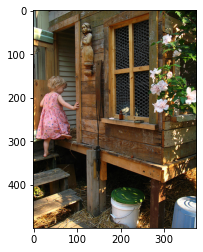

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [6]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

Next we create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions in the data set. We have 8828 unique words across all the 40000 image captions.

In [7]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]

print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


Now lets save the image id’s and their new cleaned captions in the same format as the token.txt file:-

In [8]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

Next we load all the 6000 training image id’s in a variable train from the ‘Flickr_8k.trainImages.txt’ file :-

In [9]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)
print('Train Dataset size: %d' % len(train))

Train Dataset size: 6000


In [10]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)
        
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

Now, we load the descriptions of the training images from into a dictionary. However, we will add two tokens in every caption, which are ‘startseq’ and ‘endseq’ :-

In [11]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

print('Descriptions: train = %d' % len(train_descriptions))

Descriptions: train = 6000


In [12]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

To make our model more robust we will reduce our vocabulary to only those words which occur at least 10 times in the entire corpus.

In [13]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


Now we create two dictionaries to map words to an index and vice versa. Also we append 1 to our vocabulary since we append 0’s to make all captions of equal length.

In [14]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [15]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1660

Hence now our total vocabulary size is 1660.
We also need to find out what the max length of a caption can be since we cannot have captions of arbitrary length.

In [16]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc

max_length = max(len(d.split()) for d in lines)
print('Description Length: %d' % max_length)

Description Length: 38


# Glove Embeddings
Word vectors map words to a vector space, where similar words are clustered together and different words are separated. The advantage of using Glove over Word2Vec, is that GloVe does not just rely on the local context of words but it incorporates global word co-occurrence to obtain word vectors.
The basic premise behind Glove is that we can derive semantic relationships between words from co-occurrence matrix.
For our model, we will map all the words in our 38 word long caption to a 200-dimension vector using Glove.

In [17]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

Next we make the matrix of shape (1660,200) consisting of our vocabulary and the 200-d vector.

In [18]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Model Building and Training

As you have seen from our approach we have opted for transfer learning using InceptionV3 network which is pre-trained on the ImageNet dataset.

In [19]:
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


We must remember that we do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the inceptionV3 model.

In [20]:
model_new = Model(model.input, model.layers[-2].output)

Since we are using InceptionV3 we need to pre-process our input before feeding it into the model. Hence we define a preprocess function to reshape the images to (299 x 299) and feed to the preprocess_input() function of keras.

In [21]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

Now we can go ahead and encode our training and testing images, i.e extract the images vectors of shape (2048, )

In [22]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [23]:
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)

train_features = encoding_train

In [24]:
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

Now let's define our model.
We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps:

1. Processing the sequence from the text
2. Extracting the feature vector from the image
3. Decoding the output by concatenating the above two layers

In [25]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

Input_3 is the partial caption of max length 34 which is fed into the embedding layer. This is where the words are mapped to the 200-d Glove embedding. It is followed by a dropout of 0.5 to avoid overfitting. This is then fed into the LSTM for processing the sequence.

Input_2 is the image vector extracted by our InceptionV3 network. It is followed by a dropout of 0.5 to avoid overfitting and then fed into a Fully Connected layer.

Both the Image model and the Language model are then concatenated by adding and fed into another Fully Connected layer. The layer is a softmax layer which provides probabilities to our 1660 word vocabulary.

We also need to keep in mind that we do not want to retrain the weights in our embedding layer (pre-trained Glove vectors).

In [26]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

Since our dataset has 6000 images and 40000 captions we will create a function that can train the data in batches.

In [28]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

Next let's train our model for 30 epochs with batch size of 3 and 2000 steps per epoch.The complete training of the model took 1 hour and 40 minutes.

In [50]:
epochs = 10
batch_size = 3
steps = len(train_descriptions)//batch_size

In [51]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/10
2000/2000 [==============================] - 218s 109ms/step - loss: 2.1319
Epoch 2/10
2000/2000 [==============================] - 224s 112ms/step - loss: 2.1159
Epoch 3/10
2000/2000 [==============================] - 222s 111ms/step - loss: 2.1102
Epoch 4/10
2000/2000 [==============================] - 219s 109ms/step - loss: 2.1086
Epoch 5/10
2000/2000 [==============================] - 220s 110ms/step - loss: 2.1059
Epoch 6/10
2000/2000 [==============================] - 227s 114ms/step - loss: 2.1070
Epoch 7/10
2000/2000 [==============================] - 217s 108ms/step - loss: 2.1033
Epoch 8/10
2000/2000 [==============================] - 218s 109ms/step - loss: 2.1022
Epoch 9/10
2000/2000 [==============================] - 219s 110ms/step - loss: 2.0972
Epoch 10/10
2000/2000 [==============================] - 220s 110ms/step - loss: 2.0941


# Greedy and Beam Search

As the model generates a 1660 long vector with a probability distribution across all the words in the vocabulary we greedily pick the word with the highest probability to get the next word prediction. This method is called Greedy Search.

In [52]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Beam Search is where we take top k predictions, feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions. In the end, we take the one with the highest probability and go through it till we encounter 'endseq' or reach the maximum caption length.

In [53]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

# Evaluation
Let's now test our model on different images and see what captions it generates. We will also look at the different captions generated by Greedy search and Beam search with different k values.

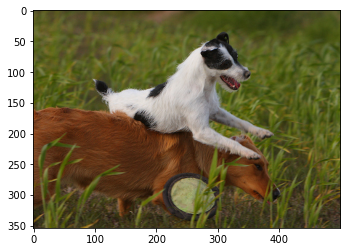

Greedy: a dog runs through the grass
Beam Search, K = 3: a brown and white dog is running through a grassy field
Beam Search, K = 5: a brown and white dog is playing with a ball in the grass
Beam Search, K = 7: a brown and white dog is playing with a frisbee
Beam Search, K = 10: there is a brown and white dog playing with a stick


In [68]:
pic = list(encoding_test.keys())[900]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

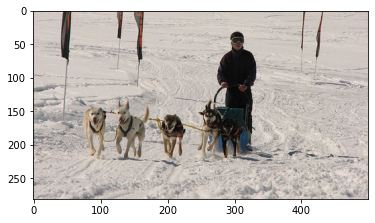

Greedy: a dog runs through the snow
Beam Search, K = 3: a group of people pulling a sled through the snow
Beam Search, K = 5: a dog runs through the snow
Beam Search, K = 7: a large group of dogs pulling a sled through the snow
Beam Search, K = 10: a large group of dogs pulling a sled through the snow


In [76]:
pic = list(encoding_test.keys())[999]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

# Whats Next?
What we have developed today is just the start. There has been a lot of research on this topic and you can make much better Image caption generators.

Things u can implement to improve your model:-
* Make use of the larger datasets, especially the MS COCO dataset or the Stock3M dataset which is 26 times larger than MS COCO.
* Making use of an evaluation metric to measure the quality of machine generated text like BLEU (Bilingual evaluation understudy).
* Implementing an Attention Based model :- Attention based mechanisms are becoming increasingly popular in deep learning because they can address these limitations. They can dynamically focus on the various parts of the input image while the output sequences are being produced.
* Image-based factual descriptions are not enough to generate high-quality captions. External knowledge can be added in order to generate attractive image captions. Therefore working on Open domain datasets can be an interesting prospect.